In [1]:
#%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker, cm
from matplotlib.ticker import LogFormatter
from scipy.optimize import curve_fit
import copy
import os
import h5py
import json
import glob                         # Per manipolazione dei path
from collections.abc import Iterable
from Allineamento import *
import Utils_v2
from Utils_v2 import *
import sys

Swan = ("swan" in sys.executable) or ("cern" in sys.executable)
print('Swan ', Swan)

Year = 2024
Material = "TECHNO"
#if Material_h != '': Material_h == '_' + Material_h

Swan  False


In [2]:
dizi,dizi_setup, _ = configurator(Year,Material,Swan)
if Swan:
    data_dir = dizi['data_path_Swan']
else:
    data_dir = dizi['data_path_local']

# nRun = dizi["RunAllignment"]
# [590454,590456,590461,590462]
nRun = 590454
# nRun = 590305
print(nRun)
data_path = f'{data_dir}/run{nRun}.h5'
print(data_path)


590454
./data/run590454.h5


In [3]:
pos= []
with h5py.File(data_path, 'r', libver='latest', swmr=True) as hf:
    print(hf.keys())
    print(hf["xpos"].shape)
    pos.append(np.array(hf[dizi_setup["pos_lbl"]]))


xpos = np.concatenate(pos,axis=0)
if (nRun > 590452) & ((nRun <= 590467) or nRun >= 590478):
        xpos = xpos[:, :4]
        T3 = False
else: T3 = True
print("xpos shape:", np.shape(xpos)) ## to autoselect the type of measurement 
print(np.min(xpos))
logic_pos = (xpos > 0 ) & (xpos < 1.92)
logic2 = logic_pos.all(axis=1)


xpos = xpos[logic2]
d_tele12 = dizi_setup['d_12']


print("xpos shape:", np.shape(xpos)) ## to autoselect the type of measurement


<KeysViewHDF5 ['digiPH', 'digiTime', 'ievent', 'info_plus', 'nstrip', 'xinfo', 'xpos']>
(1523867, 6)
xpos shape: (1523867, 4)
-4000.0
xpos shape: (1517345, 4)


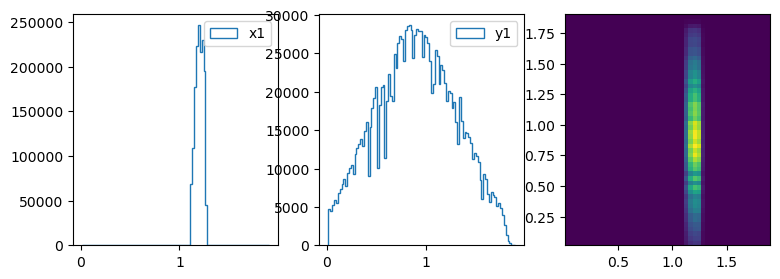

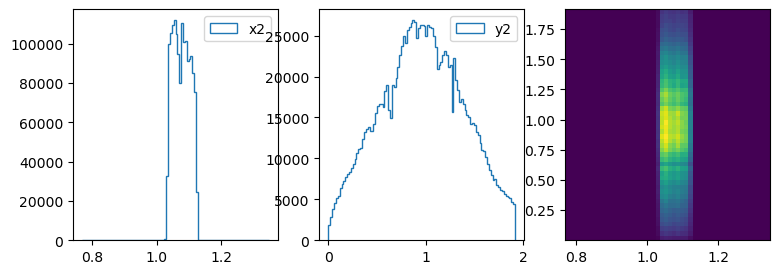

In [4]:
# definition of the actual variables
x1, y1 = xpos[:,0], xpos[:,1]
x2, y2 = xpos[:,2], xpos[:,3]
if T3:
    x3, y3 = xpos[:,4], xpos[:,5]
# ---------------------------------------------------------------
fig, ax = plt.subplots(1, 3, figsize=[9,3])
bins = 100
ax[0].hist(x1, bins=bins, label='x1', histtype='step')
ax[0].legend()
ax[1].hist(y1, bins=bins, label='y1', histtype='step')
ax[1].legend()
ax[2].hist2d(xpos[:,0], xpos[:,1], bins=[50,50])
plt.show()

fig, ax = plt.subplots(1, 3, figsize=[9,3])
ax[0].hist(x2, bins=bins, label='x2', histtype='step')
ax[0].legend()
ax[1].hist(y2, bins=bins, label='y2', histtype='step')
ax[1].legend()
ax[2].hist2d(xpos[:,2], xpos[:,3], bins=[50,50])
plt.show()
if T3:
    fig, ax = plt.subplots(1, 3, figsize=[9,3])
    ax[0].hist(x3, bins=bins, label='x3', histtype='step')
    ax[0].legend()
    ax[1].hist(y3, bins=bins, label='y3', histtype='step')
    ax[1].legend()
    ax[2].hist2d(xpos[:,4], xpos[:,5], bins=[50,50])
    plt.show()
# -----------------------------------------------------------------


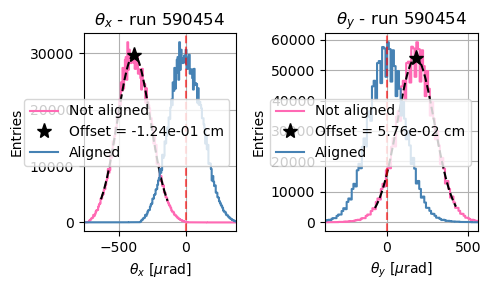

In [5]:
from Allineamento_v2 import *
cicico = align_from_xpos(nRun,xpos,dizi_setup,True)

In [ ]:
# if first alinment run ---> CHECK the order of x and y in the file generator
print("°°° CHECK ORDER OF x and y in the datafile description! °°°")


offset12, div12 = align(xpos[:,dizi_setup["index_x1"]],xpos[:,dizi_setup["index_y1"]], \
                        xpos[:,dizi_setup["index_x2"]],xpos[:,dizi_setup["index_y2"]], dizi_setup["d_12"], True)
print(offset12)
print(div12)
# offset12, div12 = align(xpos[:,0],xpos[:,1], xpos[:,2],xpos[:,3], dizi["d_12"], True) #23 ID Y = 1, ID X = 0
# xpos[:,2] -= offset12[0]  
# xpos[:,3] -= offset12[1]  
xpos[:,dizi_setup["index_x2"]] -= offset12[0]  
xpos[:,dizi_setup["index_y2"]] -= offset12[1]  
x1 = xpos[:,dizi_setup["index_x1"]]
y1 = xpos[:,dizi_setup["index_y1"]]
x2 = xpos[:,dizi_setup["index_x2"]]
y2 = xpos[:,dizi_setup["index_y2"]]
#######################################################################################
if T3:
    print("--> Now aligning T3 <-- \nat distance from T1:", dizi["d_13"])


    offset13, div13 = align(xpos[:,dizi_setup["index_x1"]],xpos[:,dizi_setup["index_y1"]], xpos[:,dizi_setup["index_x3"]],xpos[:,dizi_setup["index_y3"]], dizi_setup["d_13"], True)
    xpos[:,dizi_setup["index_x3"]] -= offset13[0]
    xpos[:,dizi_setup["index_y3"]] -= offset13[1]
    x3 = xpos[:,dizi_setup["index_x3"]]
    y3 = xpos[:,dizi_setup["index_y3"]] 

In [ ]:
v1=False
if v1:
    xypos = [x1,y1,x2,y2] if T3 == False else [x1,y1,x2,y2,x3,y3]
    
    fig, axes = plt.subplots(3,2)
    fig.subplots_adjust(wspace=.5,hspace=.5)
    fig.set_size_inches(8,8)
    
    n_rows = 2 if T3 == False else 3
    
    for i in range(n_rows): ## to 3 se 3 tele
        ax = axes[i,0]
        ax.set_title(f"Tele {i+1} - x proj")
        h, c = np.histogram(xypos[2*i], bins = 50) #23 ID Y = 1, ID X = 0
        c = c[:-1] + (c[1]+c[0])/2
       
        ax.plot(c, h, ds = 'steps-mid', c = 'hotpink')
        # ax.set_xlim(-1,2.5)
        ax.set_xlabel("x pos [cm]")
        ax.set_ylabel("Counts")
        ax.grid()
       
        ax = axes[i,1]
        ax.set_title(f"Tele {i+1} - y proj")
        h, c = np.histogram(xypos[2*i+1], bins = 50) #23 ID Y = 1, ID X = 0
        c = c[:-1] + (c[1]+c[0])/2
       
        ax.plot(c, h, ds = 'steps-mid', c = 'hotpink')    
       
        # ax.set_xlim(-1,2.5)
        ax.set_xlabel("y pos [cm]")
        ax.set_ylabel("Counts")
        ax.grid()
        plt.show()

else:
    xypos = [x1, y1, x2, y2] if T3 == False else [x1, y1, x2, y2, x3, y3]
    n_rows = 2 if T3 == False else 3
    
    fig, axes = plt.subplots(n_rows, 2)
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    fig.set_size_inches(8, 8)
    
    for i in range(n_rows):
        for j in range(2):
            ax = axes[i, j]
            ax.set_title(f"Tele {i+1} - {'x' if j == 0 else 'y'} proj")
            h, c = np.histogram(xypos[2*i + j], bins=50)
            c = c[:-1] + np.diff(c) / 2
    
            ax.plot(c, h, ds='steps-mid', c='hotpink')
            ax.set_xlabel(f"{'x' if j == 0 else 'y'} pos [cm]")
            ax.set_ylabel("Counts")
            ax.grid()
    
    plt.show()

In [ ]:
lstCoord = ["x1","y1","x2","y2"] if T3 == False else ["x1","y1","x2","y2","x3","y3"]


#fig, ax = plt.subplots(1,int(len(xpos[1,:4]))-2)
fig, ax = plt.subplots(1,int(len(lstCoord)/2))
fig.set_size_inches(9,4.5)
fig.subplots_adjust(wspace=.5,hspace=.5)


for i in range(int(len(lstCoord)/2)):
    # print(f'{i+1}-{(len(xpos[1,:]))}')
    if i <= 3:
        ax[i].hist2d(xypos[2*i],xypos[2*i+1],bins=75)
        ax[i].set_xlabel(lstCoord[2*i],fontsize = 14)
        ax[i].set_ylabel(lstCoord[2*i+1], fontsize = 14)  
plt.show()


In [ ]:
range_hist = [[-500,500],[-500,500]]
dist_chambers = d_tele12


deltaX = x2-x1 # tele 2-1
deltaY = y2-y1


theta_12_x = np.arctan(deltaX/dist_chambers) * 1e6 # urad
theta_12_y = np.arctan(deltaY/dist_chambers) * 1e6 # urad


theta12 = [theta_12_x, theta_12_y]
thetaLbl = ["x", "y"]
num_bins = 200

fig, ax = plt.subplots(2,2)
ax[1, 1].remove()
fig.set_size_inches(14,8)
plt.subplots_adjust(hspace=0.5,wspace =0.3)


titles = [fr"$\theta_X in 12$ ", fr"$\theta_Y in12 $"]
popt_list12 =[]
for i in range(2):
    h, bins = np.histogram(theta12[i], bins = num_bins, range=range_hist[i] )
    binc = bins[:-1] + (bins[1] - bins[0]) / 2


    p0 = (np.max(h), binc[np.argmax(h)], np.std(theta12[i]))
    cond = h>0
    popt, pcov = curve_fit(myGauss, binc[cond], h[cond], sigma = np.sqrt(h[cond]), absolute_sigma = True, p0 = p0)
    popt_list12.append(popt[1])
    ax[0,i].plot(binc, h, ds = "steps-mid", c = "hotpink", lw = .7,
               label = fr"$\theta_{thetaLbl[i]}$")
    ax[0,i].plot(binc, myGauss(binc, *popt), ls = "--", c = "k", label = f"Fit ({popt[1]:.2f} $\pm$ {popt[2]:.2f} urad)")
    ax[0,i].grid()
    ax[0,i].set_title(titles[i])
    ax[0,i].set_ylabel("Entries", fontsize = 10)    
    ax[0,i].set_xlabel(r"$\theta$ [urad]",fontsize = 10)
    ax[0,i].legend(fontsize = 10)
   
    print(f"La divergenza in {thetaLbl[i]} vale {popt[2]:.2f} urad")

# Creazione del plot
ax[1,0].hist2d(theta12[0], theta12[1], bins=num_bins, range = range_hist)

# Etichette degli assi
ax[1,0].grid()
ax[1,0].set_xlabel(r'$\theta_{x}$')
ax[1,0].set_ylabel(r'$\theta_{y}$')
       
plt.show()


In [ ]:
#DUMP THE OFFSET IN THE CONFIG FILE
config_file_h = "./config_TECHNO_24.json"

dizi["offset_x2"] = offset12[0]
dizi["offset_y2"] = offset12[1]
if T3 == True:
    dizi["offset_x3"] = offset13[0]
    dizi["offset_y3"] = offset13[1]
dizi["div_12x"]   =  div12[0]
dizi["div_12y"]   =  div12[1]
print(dizi)
with open(config_file_h, "w") as f:
            json.dump(dizi, f, indent=4)
print(dizi)